In [1]:
import pandas as pd
import numpy as np
import entropy_utils as eu
import random
import tqdm

In [5]:
metadata = pd.read_csv("/scratch/jho5ze/bionets/covid/variant_data/metadata.tsv", sep="\t", parse_dates = ["Collection date", "Submission date"])
# print(metadata.columns)
# metadata = metadata[["Accession ID", \
#                    "Collection date", \
#                    "Submission date", \
#                    "Location", \
#                    "Additional location information", \
#                    "Sequence length", \
#                    "Host", \
#                    "AA Substitutions", \
#                    "Is reference?", \
#                    "Pango lineage"]]
def get_nth_slash(row, n):
    try:
        return row.split("/")[n].strip()
    except:
        return np.nan
    
for i in range(4):
    metadata[f"Location_{i}"] = metadata["Location"].apply(lambda row: get_nth_slash(row, i))
metadata = metadata.rename(columns={"Location_1":"country", "Location_2":"state"})
metadata = metadata[metadata["country"] == "USA"]
metadata["alias"] = metadata["Virus name"].apply(lambda row: "/".join(row.split("/")[2:]))
# metdata = metadata.rename(columns={"Accession ID":"EPI"})

/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2020.11-py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
va_metadata = metadata[metadata.state == "Virginia"]
va_metadata["alias"] = va_metadata.alias.apply(lambda row: row.split("/")[0])
id_to_accession = va_metadata.set_index("alias")["Accession ID"].to_dict()
# va_metadata[va_metadata.alias.isin(variants["DCLS Sequencing ID"])]

<ipython-input-7-b89680a04ba5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  va_metadata["alias"] = va_metadata.alias.apply(lambda row: row.split("/")[0])


In [15]:
alias = va_metadata["Virus name"].tolist() #.apply(lambda row: row.split("/")[2].split("-")[0]).value_counts()
alias[:10] #[i for i in alias if "CAV" in i]

['hCoV-19/USA/VA-DCLS-4481/2021',
 'hCoV-19/USA/VA-DCLS-4495/2021',
 'hCoV-19/USA/VA-DCLS-4581/2021',
 'hCoV-19/USA/VA-DCLS-4584/2021',
 'hCoV-19/USA/VA-DCLS-4585/2021',
 'hCoV-19/USA/VA-DCLS-4590/2021',
 'hCoV-19/USA/VA-DCLS-4592/2021',
 'hCoV-19/USA/VA-DCLS-4601/2021',
 'hCoV-19/USA/VA-CDC-2-4855871/2021',
 'hCoV-19/USA/VA-CDC-2-4855891/2021']

In [ ]:
variants = pd.read_csv("/sfs/qumulo/qproject/biocomplexity/COVID-19_commons/products/external_data_collection/VDH_opioids/VDH-UVA-DSA-COVID-19-Variant.tsv", sep="\t", parse_dates=["Report Date", "Event_Dt_Upd", "WEEK_END_DT_CDC"], dtype={"PATIENT_COUNTY":str}) #, parse_dates=["report_date", "date"], dtype={"fips":str})
print(variants.head())
for i in variants.COVID_19_VARIANT.unique():
    print(i)

In [2]:
variants = pd.read_csv("/sfs/qumulo/qproject/biocomplexity/COVID-19_commons/products/external_data_collection/VDH_opioids/VDH-UVA-DSA-COVID-19-Variant.tsv", sep="\t", parse_dates=["Report Date", "Event_Dt_Upd", "WEEK_END_DT_CDC"], dtype={"PATIENT_COUNTY":str}) #, parse_dates=["report_date", "date"], dtype={"fips":str})
print(variants.head())
variants = variants[["Report Date", "WEEK_END_DT_CDC", "Event_Dt_Upd", "PATIENT_COUNTY", "DCLS Sequencing ID"]]
# print(sorted(variants.WEEK_END_DT_CDC.unique()))
# variants = variants[("2021-07-01" < variants.WEEK_END_DT_CDC) & (variants.WEEK_END_DT_CDC < "2021-08-21")]
variants = variants[variants["DCLS Sequencing ID"].isin(va_metadata.alias)]
variants["accession"] = variants["DCLS Sequencing ID"].apply(lambda row: id_to_accession[row])
all_fips = variants.PATIENT_COUNTY.unique().astype(str).tolist()
variants["Event_Dt_Upd"].value_counts().sum()

variants["is_in_msadb"] = variants.accession.apply(lambda row: row in eu.msadb)
# variants = variants[variants.is_in_msadb == True]
print(variants.shape)

  COVID_19_VARIANT Specimen_Id  Report Date VARIANT_CLEAN Vaccine Age group  \
0  B.1.1.7 - Alpha   R210410256  2021-11-15       B.1.1.7       65-74 Years   
1  B.1.1.7 - Alpha   R210504305  2021-11-15       B.1.1.7         0-4 Years   
2  B.1.1.7 - Alpha   R210504949  2021-11-15       B.1.1.7       35-44 Years   
3  B.1.1.7 - Alpha   R210504950  2021-11-15       B.1.1.7       65-74 Years   
4  B.1.1.7 - Alpha   R210505666  2021-11-15       B.1.1.7       18-24 Years   

     Age Group  Patient Age in Years Tiered Race Ethnicity  Variant Count  \
0  60-69 Years                    69                 Black              1   
1    0-9 Years                     0            Other Race              1   
2  30-39 Years                    36          Not Reported              1   
3  70-79 Years                    70                 Black              1   
4  20-29 Years                    20                 White              1   

   Death Count  ...  PATIENT_CURRENT_SEX PATIENT_COUNTY OUTBRE

NameError: name 'va_metadata' is not defined

<AxesSubplot:xlabel='Event_Dt_Upd'>

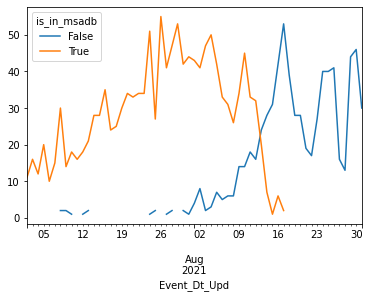

In [8]:
data = variants.groupby("is_in_msadb")["Event_Dt_Upd"].value_counts() #.reset_index() #.plot()
data.rename("count").reset_index().pivot(index="Event_Dt_Upd", columns = "is_in_msadb", values="count").plot()

<AxesSubplot:xlabel='WEEK_END_DT_CDC'>

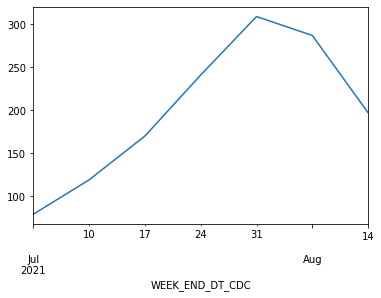

In [40]:
variants.groupby("WEEK_END_DT_CDC").count()["accession"].plot()

In [80]:
fips_groups = dict()
groups_fips = dict()
with open("../data/network.tree") as src:
    for line in src.readlines():
        if line[0] == "#":
            continue
            
        module, weight, _, fips = line.split()
        if fips not in all_fips:
            continue
        cluster = module.split(":")[0]
        fips_groups[fips] = cluster
        groups_fips.setdefault(int(cluster), []).append(fips)
        


In [ ]:
"""Sample 400 of them"""

<AxesSubplot:xlabel='Event_Dt_Upd'>

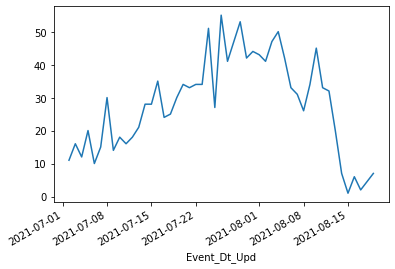

In [37]:
variants.groupby("Event_Dt_Upd").count()["accession"].plot()

In [85]:
class FipsNode:
    all_fips = []
    fips_data = None
    date_data = None
    data = None
    def __init__(self, fips, data):
        random.shuffle(fips)
        self.fips = fips
        self.data = data.copy()
        
    def get_next_accession(self, date):

        date_data = self.data[self.data.WEEK_END_DT_CDC == date]
        data_fips = date_data.PATIENT_COUNTY.unique().tolist()

        found_a_fips = False
        
        for ix, fips in enumerate(all_fips):
            if fips in data_fips:
                found_a_fips = True
                break
        
        if not found_a_fips:
            return ""
        
        else:
            all_fips.pop(ix)
            all_fips.append(fips)
            accession = date_data[date_data.PATIENT_COUNTY == fips].accession.sample().tolist()[0]
            self.data = self.data[self.data.accession != accession]

            return accession
    

In [88]:
random_sample_list = []
strat_sample_list = []

for sample_ix in range(10):
    random_sample = []
    strat_sample = []
    
    nodes = [FipsNode(groups_fips[ix+1], variants) for ix in range(9)]
    
    for date in variants.WEEK_END_DT_CDC.unique():
        accessions = variants[variants.WEEK_END_DT_CDC == date].accession.tolist()
        randoms = random.sample(accessions, 50)
        random_sample.extend(randoms)
        for ix in range(50):
            strat_ix = nodes[ix%9].get_next_accession(date)
            strat_sample.append(strat_ix)
            
    random_sample_list.append(random_sample)
    strat_sample_list.append(strat_sample)
            
    
# len(strat_sample)

In [91]:
len(set(random_sample_list[0]) & set(strat_sample_list[0]))

106

In [94]:
len(strat_sample_list[0])

350

In [113]:
sample_count = 400

strat_samples = []
strat_samples_fips = []
for sample_ix in range(30):
    
    fips_ids = dict()
    for fips, sid in variants[["PATIENT_COUNTY", "accession"]].to_numpy(): #.set_index("PATIENT_COUNTY")["DCLS Sequencing ID"]
        fips_ids.setdefault(fips, []).append(sid)

    for fips in fips_ids:
        random.shuffle(fips_ids[fips])

    current_group_count = {i:0 for i in range(1,10)}
    
    sample = []
    sample_fips = []
    for ix in range(sample_count):
        group = 1 + (ix % 9)
        fips = ""
        tries = 0
        while fips == "" and tries < len(groups_fips[group]):
            try_fips = groups_fips[group][current_group_count[group]]
            if fips_ids[int(try_fips)]:
                fips = try_fips
                sample.append(fips_ids[int(fips)].pop()) 
                sample_fips.append(fips)
            else:
                tries += 1
        current_group_count[group] = (current_group_count[group] + 1 + tries) % len(groups_fips[group])
        
    strat_samples.append(sample)
    strat_samples_fips.append(sample_fips)

random_samples = []
for sample_ix in range(30):
    sample = variants["accession"].tolist()
    sample = random.sample(sample, 300)
        
    random_samples.append(sample)

In [147]:
len(set(strat_samples[0]).intersection(set(random_samples[0])))

47

In [122]:
pd.read_csv("/sfs/qumulo/qproject/biocomplexity/COVID-19_commons/products/external_data_collection/VDH_public/VDH-COVID-19-PublicUseDataset-Cases-by-Vaccination-Status.csv").vaccination_status.unique()

array(['Fully Vaccinated', 'Partially Vaccinated', 'Unvaccinated'],
      dtype=object)

In [141]:
names = []
seqs = []
for line in eu.msa_from_screed_ids(strat_samples[0][:6]):
    if line[0] == ">":
        names.append(line)
    else:
        l = []
        for c in line:
            l.append(c)
        seqs.append(l)

In [132]:
seqs[0][400:410]

['C', 'A', 'C', 'A', 'C', 'G', 'T', 'C', 'C', 'A']

In [142]:
len(names)

4

In [127]:
ixs = []
for ix, ch in enumerate(seqs[0]):
    has_dash = 0
    for s in seqs:
        if s[ix] == "-":
            has_dash += 1
    if has_dash == len(seqs):
        ixs.append(ix)

In [145]:
with open("test.msa", "w") as dest:
    for six in range(len(seqs)):
        dest.write(names[six] + "\n")
        seq = "".join([i for ix, i in enumerate(seqs[ix]) if ix not in ixs])
        dest.write(seq + "\n")

In [89]:
for ix, samples in enumerate(strat_sample_list):
    print("On strat", ix)
    with open(f"msas/strategy_sampled_msa_temporal_{ix}.txt", "w") as dest:
        for lx, line in enumerate(eu.msa_from_screed_ids(samples)):
            if lx % 100 == 0:
                print("At ", (lx / 300) * 100, "%")
            dest.write(line + "\n")
            
    samples = random_sample_list[ix]
    print("On random")
    with open(f"msas/random_sampled_msa_temporal_{ix}.txt", "w") as dest:
        for lx, line in enumerate(eu.msa_from_screed_ids(samples)):
            if lx % 100 == 0:
                print("At ", (lx / 300) * 100, "%")
            dest.write(line + "\n")
            
#     break

On strat 0
At  0.0 %
At  33.33333333333333 %
At  66.66666666666666 %
At  100.0 %
At  133.33333333333331 %
At  166.66666666666669 %
At  200.0 %
On random
At  0.0 %
At  33.33333333333333 %
At  66.66666666666666 %
At  100.0 %
At  133.33333333333331 %
At  166.66666666666669 %
At  200.0 %
On strat 1
At  0.0 %
At  33.33333333333333 %
At  66.66666666666666 %
At  100.0 %
At  133.33333333333331 %
At  166.66666666666669 %
At  200.0 %
On random
At  0.0 %
At  33.33333333333333 %
At  66.66666666666666 %
At  100.0 %
At  133.33333333333331 %
At  166.66666666666669 %
At  200.0 %
On strat 2
At  0.0 %
At  33.33333333333333 %
At  66.66666666666666 %
At  100.0 %
At  133.33333333333331 %
At  166.66666666666669 %
At  200.0 %
On random
At  0.0 %
At  33.33333333333333 %
At  66.66666666666666 %
At  100.0 %
At  133.33333333333331 %
At  166.66666666666669 %
At  200.0 %
On strat 3
At  0.0 %
At  33.33333333333333 %
At  66.66666666666666 %
At  100.0 %
At  133.33333333333331 %
At  166.66666666666669 %
At  200.0 %
On

In [ ]:
for ix, samples in enumerate(random_samples):
    with open(f"msas/strategy_sampled_msa_{ix}.txt", "w") as dest:
        for line in eu.msa_from_screed_ids(samples):
            dest.write(line)